# Import Libraries

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont

In [2]:
from utils import load_sessions, read_session
from main import generate_buffer
from events import generate_event_seq
from summary import stats

# Load Session

In [3]:
session = load_sessions()

for idx, sess in enumerate(session):
    if sess == "./coauthor-v1.0/7c1e066d0c9c4901921cab117a0b7e73.jsonl":
        break
        
# session = session[idx]
session = session[4]
print(session)

Successfully downloaded 1447 writing sessions in CoAuthor!
./coauthor-v1.0/2b2239b180604f018998fa272576c828.jsonl


# Compute Event Sequence

In [4]:
events = read_session(session, verbose=0)
text_buffer = generate_buffer(events)
event_seq_dict = generate_event_seq(buffer=text_buffer, events=events)

# Graph Config

In [5]:
margin = 25
# circle_size = 50
circle_size = 20
sentence_margin = 80

x_padding = 50
y_padding = 30

line_size = x_padding

In [6]:
y_len = len(event_seq_dict["num_sent"]) - 1
x_len = np.max([len(x) for x in event_seq_dict["sequence"]]) - 1
image_height = (margin * 2) + (y_padding * y_len) + circle_size
image_width = sentence_margin + (margin * 2) + (x_padding * x_len) + circle_size

# Initialize Graph

In [7]:
image = Image.new("RGB", (image_width, image_height), "white")
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# Define Graph Function

In [8]:
def user_square(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x
    y_start = margin + y_padding * y
#     draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
#                  fill = (100, 255, 100, 255), outline ='black')
    draw.rectangle((x_start, y_start, x_start+circle_size, y_start+circle_size),
                   fill = (100, 255, 100, 255), outline ='black')

def text(text, y):
    y -= 1
    x_start = margin
    y_start = margin + (circle_size/3) + y_padding * y
    draw.text((x_start,y_start), text, fill='black', font=font)


def gpt_triangle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x
    y_start = margin + y_padding * y
#     draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
#                  fill = "red", outline ='black')
    draw.polygon([(x_start+circle_size/2, y_start), (x_start, y_start+circle_size), 
                  (x_start+circle_size,y_start+circle_size)],
                 fill = "blue", outline ='black')


def prompt_circle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x
    y_start = margin + y_padding * y
    draw.ellipse((x_start, y_start, x_start+circle_size, y_start+circle_size), 
                 fill = "black", outline ='black')
    

def modified_triangle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x
    y_start = margin + y_padding * y
    draw.polygon([(x_start+circle_size/2, y_start), (x_start, y_start+circle_size), 
                  (x_start+circle_size,y_start+circle_size)],
                 fill = "grey", outline ='black')
    

def empty_triangle(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x
    y_start = margin + y_padding * y
    draw.polygon([(x_start+circle_size/2, y_start), (x_start, y_start+circle_size), 
                  (x_start+circle_size,y_start+circle_size)],
                 fill = "white", outline ='black')
    

def suggestion_open(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x + circle_size/2
    y_start = margin + (circle_size/2) + y_padding * y
#     draw.line([(x_start, y_start),
#               (x_start+line_size, y_start)], fill='red', width=3)
    draw.line([(x_start, y_start),
              (x_start-line_size, y_start)], fill='red', width=3)

def user_change(x, y):
    x -= 1
    y -= 1
    x_start = sentence_margin + margin + x_padding * x + circle_size/2
    y_start = margin + (circle_size/2) + y_padding * y
#     draw.line([(x_start, y_start),
#               (x_start-line_size, y_start)], fill= (100, 255, 100, 255), width=3)
    # Dotted line
    x_start = int(x_start)
    for dash in range(x_start, x_start-line_size, -4):
        draw.line([(dash, y_start), (dash-2, y_start)], fill="orange", width=3)

# Draw Graph

In [9]:
for idx, event_seq in enumerate(event_seq_dict["sequence"]):
    image_text = "Sentence " + str(idx+1)
#     text(image_text, idx+1)
    for i, op in enumerate(event_seq):
        if op == "gpt3-call" and i != 0:
            suggestion_open(i+1, idx+1)
        if op == "user" and i != 0:
            user_change(i+1, idx+1)
        if op == "modify-gpt3" and i != 0:
            user_change(i+1, idx+1)
        if op == "empty-call" and i != 0:
            suggestion_open(i+1, idx+1)

            
for idx, event_seq in enumerate(event_seq_dict["sequence"]):
    image_text = "Sentence " + str(event_seq_dict["num_sent"][idx])
    text(image_text, idx+1)
#     text(image_text, event_seq_dict["num_sent"][idx])
    for i, op in enumerate(event_seq):
        if op == "gpt3-call":
            gpt_triangle(i+1, idx+1)
        if op == "user":
            user_square(i+1, idx+1)
        if op == "prompt":
            prompt_circle(i+1, idx+1)
        if op == "modify-gpt3":
            modified_triangle(i+1, idx+1)
        if op == "empty-call":
            empty_triangle(i+1, idx+1)

# Display Graph

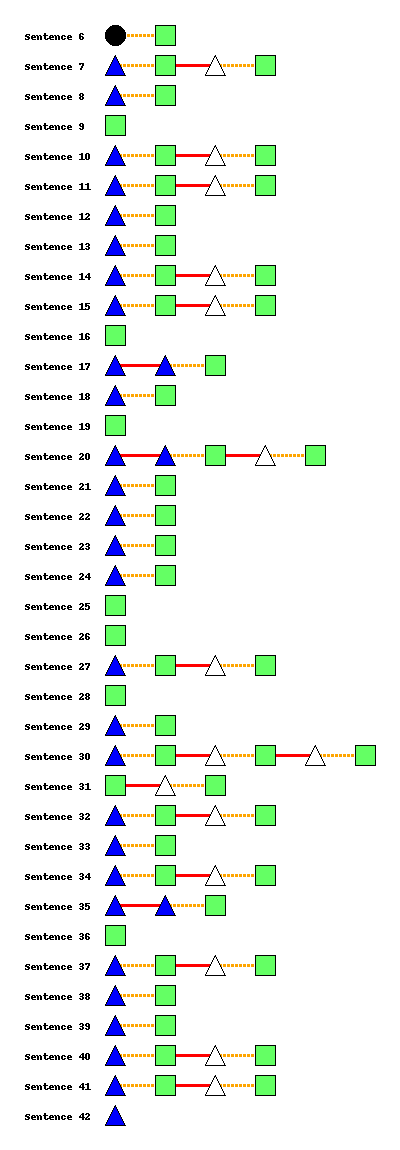

In [10]:
display(image)

# Draw Graph Legend

In [11]:
legend_seq = np.array([
    np.array(["prompt"]),
    np.array(["user"]),
    np.array(["gpt3-call"]),
    np.array(["modify-gpt3"]),
    np.array(["empty-call"]),
])

In [12]:
margin = 25
# circle_size = 50
circle_size = 20
sentence_margin = 80

x_padding = 50
y_padding = 30

line_size = x_padding

In [13]:
y_len = len(legend_seq) - 1
x_len = np.max([len(x) for x in legend_seq]) - 1
image_height = (margin * 2) + (y_padding * y_len) + circle_size
image_width = sentence_margin + (margin * 2) + (x_padding * x_len) + circle_size

In [14]:
image = Image.new("RGB", (image_width, image_height), "white")
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

In [15]:
for idx, event_seq in enumerate(legend_seq):
    text(str(event_seq[0]), idx+1)
    for i, op in enumerate(event_seq):
        if op == "gpt3-call":
            gpt_triangle(i+1, idx+1)
        if op == "user":
            user_square(i+1, idx+1)
        if op == "prompt":
            prompt_circle(i+1, idx+1)
        if op == "modify-gpt3":
            modified_triangle(i+1, idx+1)
        if op == "empty-call":
            empty_triangle(i+1, idx+1)

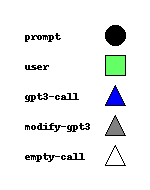

In [16]:
display(image)